## Vectorization of resulst

1. run inference (DONE - other notebook)
2. vectorize (DONE - this notebook)

#### to be done in this notebook: 
3. select random sample from inference (n = depending on how much we need to achieve accuracy)
4. plot over satellite image
5. ask user input
6. store user input

#### to be done in other notebook:

7. get pixel values 
8. retrain model, inputs:
    - existing weights and 
    - new pixel data from user input

repeat 

In [3]:
# add helper function location
import sys 
sys.path.append('../../functions')

# import helper functions 
from helpers import *

In [4]:
from skimage import filters, morphology
from rasterio import features 
from shapely.geometry import shape
from shapely import geometry
import itertools

import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import geopandas as gpd

In [5]:
# functions


def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = all_rings #[g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 

# load classification raster

In [6]:
# load classified rasters 

import rasterio 
import glob
import os

from pprint import pprint

from shapely.ops import cascaded_union
import pandas as pd


name = ''

# find files in classification folder
raster_files_path = '../../data/nir_green_blue/classifications/{}*.tif'.format(name)
vectors_path = '../../data/nir_green_blue/vectors/'


raster_files = glob.glob(raster_files_path)
file_path = raster_files[1]

print(len(raster_files))
print('-------------------------------------')
pprint(raster_files[0:3])
print('-------------------------------------')
print(file_path[0:3])



502
-------------------------------------
['../../data/nir_green_blue/classifications/Jakarta_180_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif',
 '../../data/nir_green_blue/classifications/Jakarta_123_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif',
 '../../data/nir_green_blue/classifications/Medan_296_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif']
-------------------------------------
../


In [7]:
# create classification directory if it does not exist
make_dir(vectors_path)

Directory  ../../data/nir_green_blue/vectors/  already exists...


In [8]:
# set parameters:

verbose = 0


In [9]:
import random

geometry_list = []

for file_path in tqdm(raster_files):
    
    base_name = file_path.split('/')[-1].split('.')[0]

    try:
        data = rasterio.open(file_path).read()
    except Exception as e:
        print(e)
        print('skipping...')
        continue
    dataset = rasterio.open(file_path)

    affine = dataset.meta['transform']
    width = dataset.meta['width']
    height = dataset.meta['height']

    thresh = filters.threshold_otsu(data[0])
    thresh = 0.50
   

    data_otsu_treshold = data[0] > thresh

    water_data = data_otsu_treshold.astype('uint8')

    # rescale values to 0 - 255 to use image processing algorithms
    OldRange = (water_data.max() - water_data.min())  
    NewRange = (0 - 255)  
    NewValue = (((water_data - water_data.min()) * NewRange) / OldRange) + 0

    water_data_1 = NewValue.round().astype('uint8')

    water_blurred = cv.medianBlur(water_data_1,3)

    # Specify the minimum feature size in square meters, and then use info from the image metadata 
    # to translate to grid cell count.

    # Set the minimum feature size to 400 sq km (400,000 m)
    min_feature_size_m2 = 70.

    # From the image metadata, we can determine the area of a single grid cell
    try: 
        cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
    except: 
        cell_height_m = 0.40

    cell_area_m2 = cell_height_m**2

    # Finally, use the cell size to convert the minimum feature size to grid cells
    min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')



    # scikit-image modules for image science operators
    from skimage import filters, morphology

    # First, remove the small holes
    water_cleaned_1 = morphology.remove_small_holes(water_blurred, min_feature_size_cells)

    # Then remove the small objects
    water_cleaned_2 = morphology.remove_small_objects(water_cleaned_1, min_feature_size_cells, connectivity=2)
    
    if sum(sum(water_cleaned_2)) != 0:
        water_lines = array_to_linestrings(array = water_cleaned_2, mask = water_cleaned_2, affine = affine)

        # Run a basic simplification algorithm to smooth the lines
        water_lines_smooth = [g.simplify(0.001) for g in water_lines]

        # GLue it all together
        detection = cascaded_union(water_lines)

        import shapely.ops as ops
        # setu_smooth = setu_wgs.simplify(0.00003)
        detection_poly = ops.polygonize_full(detection)

        detection_poly = cascaded_union(detection_poly)

        buffer = 0# 1e-05

        detection_poly_smooth = detection_poly.buffer(-buffer).buffer(buffer)

        detection_poly_smooth

        detection_poly = ops.polygonize_full(detection_poly_smooth)[0]

        
        if verbose > 0: 
            for polygon_loop in detection_poly:
                x,y = polygon_loop.exterior.xy

                plt.plot(x,y,'r')
                plt.axis('equal')

            plt.show()
            
            # What is the minimum feature size in square meters and grid cells?
            print(min_feature_size_m2, 'sq. m')
            print(min_feature_size_cells, 'grid cells')
            
            print('source file: ', file_path)
            print('written to: ', geojson_file_path)

            print('---------------------------------------------------------')

        

        sample = random.randint(0,len(detection_poly)) - 1 


        geometry_list.append(detection_poly)

        
        
        geojson_file_path = vectors_path + '{}.geojson'.format(base_name)
    
        df = pd.DataFrame(shape(detection_poly), columns = ['geometry'])
        gpd.GeoDataFrame(df).to_file(geojson_file_path, driver='GeoJSON')


        
        

        


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/morphology/misc.py:194: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


NameError: name 'water_cleaned' is not defined

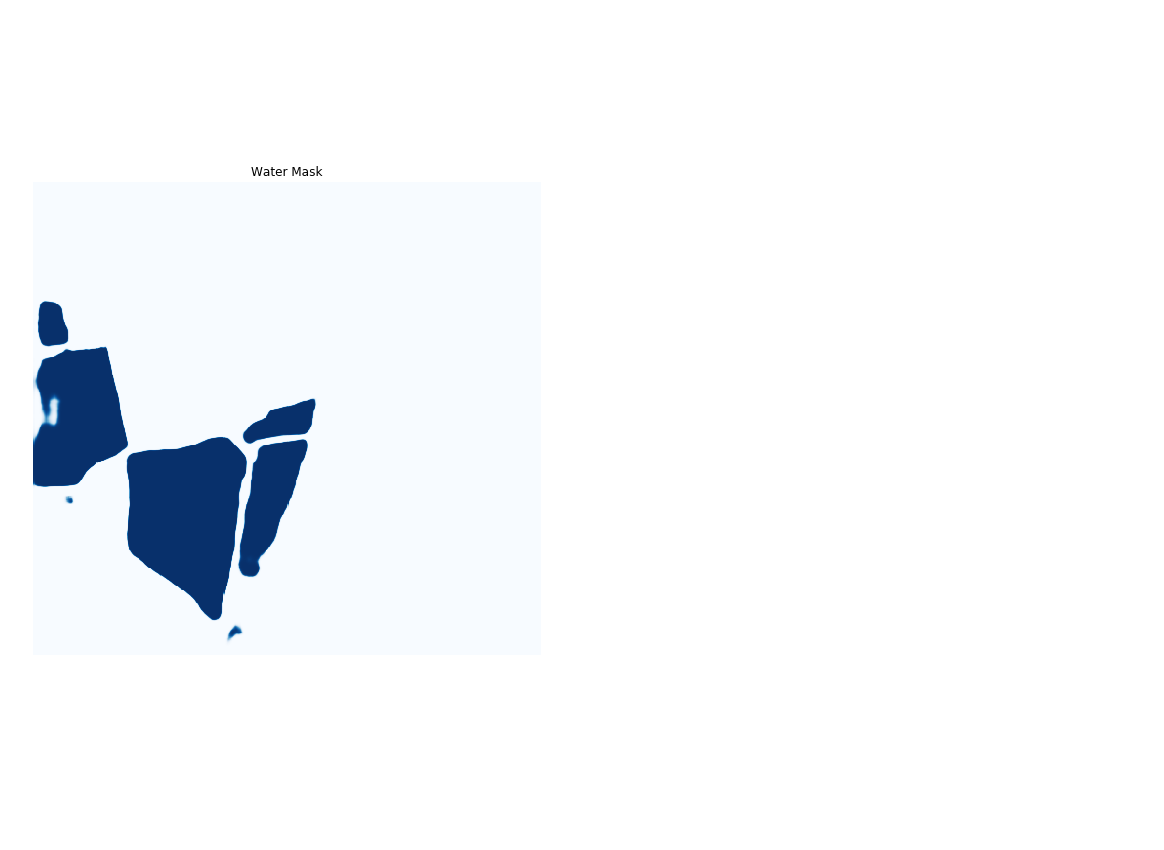

In [11]:
# # View the results
plt.figure(figsize=(20,15))
# plt.subplot(1, 3, 1)
# plt.axis('off')
# # plt.imshow(rgb)
# plt.title("RGB")

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(data[0], vmin=0, vmax=1, cmap = 'Blues')
plt.title("Water Mask")

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(water_cleaned, vmin=0, vmax=1, cmap = 'Blues')
plt.title("Cleaned Water Mask")

# Get user input

In [40]:
# df_user = []

# for poly in detection_poly:
    
#     x,y = poly.exterior.xy
    
#     fig, ax = plt.subplots()
#     ax.set_aspect('equal')
#     ax.plot(x,y, color = 'b')
# #     plt.set_aspect('equal')
#     plt.show()
    
#     human_interaction = input('is it water?: y/n')
    
#     if human_interaction == 'y': 
        
#         df_user.append('water')
#         print('label is water')
#     else: 
#         df_user.append('non_water')
#         print('label is non water')
    

# write shape to file

In [22]:
import geopandas
from datetime import datetime
from datetime import timedelta

import numpy as np
import pandas as pd

import json

from pprint import pprint

import namegenerator

In [23]:
def create_random_time_list(lenght, datetime):
    
    green_value_list = []
    date_time_green_list = []
        
    for i in range(lenght):

        new_time = date_time + timedelta(days = i/24)
        date_time_green_list.append(new_time.strftime("%Y/%m/%d %H:%M:%S"))
        green_value_list.append(np.round(1.5 * i + np.random.normal(0,1,1)[0] * 2,2))
        
    json_list_timestamps = json.dumps(date_time_green_list)
    json_list_green_over_time = json.dumps(green_value_list)
    
    
    
    return date_time_green_list, json_list_green_over_time

In [24]:
geojson_poly = geopandas.GeoSeries([detection_poly]).__geo_interface__

In [25]:
df =  pd.DataFrame(columns = ['id', 
                              'longitude',
                              'latitude',
                              '_geojson',
                              'name',
                              'time_analysis', 
                              'time_stamps',
                              'water_area_over_time',
                              'green_over_time',
                              'sediment_load_over_time',
                              'parcel_overlap' ])

now = datetime.now() # current date and time

# 1967/08/01 10:33:50.47

date_time = now
print("date and time:",date_time)

green_over_time_json_str = []
from shapely.geometry import Polygon




i_all = 0 

for geometry in geojson_poly['features'][0]['geometry']['coordinates']:
    
    x,y = Polygon(geometry[0]).representative_point().xy
    
    str_list_coords_coords = str([list(coords) for coords in geometry[0]])

    str_list_coords = '{"type":"Feature","geometry":{"type":"Polygon","coordinates":[%s]}}' % str_list_coords_coords
    
    # print(geometry)
    
    name_waterbody = namegenerator.gen(separator = ' ')
    
    time_stamps, json_list_water_area_over_time = create_random_time_list(60, now)
    time_stamps, json_list_green_over_time = create_random_time_list(60, now)
    time_stamps, json_list_sediment_load_over_time = create_random_time_list(60, now)
    
    json_list_parcel_overlap = json.dumps({'hak_milik' :10, 'none':80,'bladiebla':20})
      
    df.loc[i_all] = [i_all, 
                     x[0],
                     y[0],
                     str_list_coords,
                     name_waterbody,
                     date_time.strftime("%Y/%m/%d %H:%M:%S"), 
                     time_stamps,
                     json_list_water_area_over_time,
                     json_list_green_over_time,
                     json_list_sediment_load_over_time,
                     json_list_parcel_overlap]
    
    i_all = i_all + 1

date and time: 2020-06-28 23:12:02.238742


In [26]:
df

,id,longitude,latitude,_geojson,name,time_analysis,time_stamps,water_area_over_time,green_over_time,sediment_load_over_time,parcel_overlap
0,0,115.192837,-8.776699,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",goopy brass rhinoceros,2020/06/28 23:12:02,"[2020/06/28 23:12:02, 2020/06/29 00:12:02, 202...","[1.61, -0.01, 2.29, 5.13, 4.18, 6.4, 9.59, 11....","[1.91, 1.99, 5.5, 6.45, 3.65, 5.51, 10.46, 4.2...","[-3.23, 2.97, -0.96, 4.42, 7.93, 8.97, 9.52, 1...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
1,1,115.192102,-8.777068,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",sleazy bistre rattlesnake,2020/06/28 23:12:02,"[2020/06/28 23:12:02, 2020/06/29 00:12:02, 202...","[-0.27, 1.05, 0.68, 1.97, 7.78, 8.03, 9.27, 9....","[0.3, 0.69, 3.5, 4.89, 9.79, 6.3, 10.43, 7.35,...","[-2.24, -0.55, -1.96, 3.22, 5.0, 6.4, 8.42, 9....","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
2,2,115.192395,-8.776860,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",leaky amber mist,2020/06/28 23:12:02,"[2020/06/28 23:12:02, 2020/06/29 00:12:02, 202...","[0.19, 3.14, 1.45, 4.84, 8.32, 6.15, 8.86, 11....","[-3.15, -1.86, 5.88, 4.39, 7.5, 5.35, 8.47, 10...","[-0.94, 1.71, 3.87, 6.31, 3.23, 6.07, 8.33, 12...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
3,3,115.193667,-8.779088,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",woozy tangerine blue,2020/06/28 23:12:02,"[2020/06/28 23:12:02, 2020/06/29 00:12:02, 202...","[1.52, 1.8, 3.1, 0.59, 10.55, 5.84, 11.97, 9.3...","[-0.58, 2.12, 2.67, 2.0, 6.45, 8.75, 6.14, 14....","[0.73, 0.76, 1.22, 4.91, 4.65, 10.1, 8.8, 8.37...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
4,4,115.193856,-8.778879,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",lovely corn goat,2020/06/28 23:12:02,"[2020/06/28 23:12:02, 2020/06/29 00:12:02, 202...","[-2.56, 2.3, 1.98, 4.21, 10.32, 9.4, 9.63, 11....","[0.55, 0.54, 1.35, 2.8, 6.67, 8.94, 8.14, 14.0...","[-2.03, 1.11, 1.28, 4.63, 8.51, 7.68, 10.3, 12...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
...,...,...,...,...,...,...,...,...,...,...,...
1135,1135,106.961402,-6.101853,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",messy lime spitz,2020/06/28 23:12:02,"[2020/06/28 23:12:02, 2020/06/29 00:12:02, 202...","[2.94, 5.67, 2.22, 6.22, 4.38, 6.62, 8.57, 12....","[1.32, 1.44, 6.75, 5.2, 7.07, 12.58, 11.55, 10...","[1.95, 4.34, 0.9, 7.05, 8.53, 5.63, 8.63, 11.1...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
1136,1136,106.731615,-6.102042,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",scanty cardinal affenpinscher,2020/06/28 23:12:02,"[2020/06/28 23:12:02, 2020/06/29 00:12:02, 202...","[2.02, -0.43, 4.41, 4.24, 7.6, 8.58, 8.49, 14....","[-1.23, 2.93, 3.09, 2.89, 5.88, 6.61, 6.8, 7.1...","[0.88, 3.04, 1.05, 6.39, 3.3, 8.67, 8.89, 10.7...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
1137,1137,106.955373,-6.101687,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",craggy platinum oriole,2020/06/28 23:12:02,"[2020/06/28 23:12:02, 2020/06/29 00:12:02, 202...","[0.27, 3.6, 4.08, 6.8, 6.65, 11.46, 10.45, 9.6...","[-0.07, 2.93, 1.65, 4.84, 8.51, 4.52, 10.49, 9...","[0.93, 3.23, 1.88, 6.06, 4.55, 7.67, 8.14, 12....","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
1138,1138,106.724758,-6.101777,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",shabby dandelion stingray,2020/06/28 23:12:02,"[2020/06/28 23:12:02, 2020/06/29 00:12:02, 202...","[-3.55, 2.31, 2.56, 4.89, 4.7, 9.13, 8.41, 12....","[0.74, 1.4, 2.26, 3.49, 4.41, 8.83, 11.95, 9.4...","[2.07, 3.69, 3.34, 4.54, 6.43, 9.37, 11.52, 14...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"


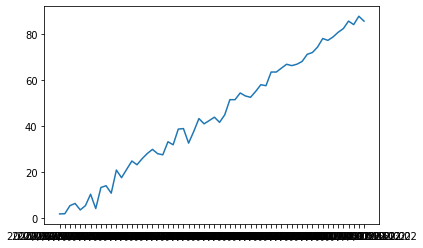

In [27]:
plt.plot(df.time_stamps[1], json.loads(df.green_over_time[0]))

In [28]:
df.green_over_time[0]

'[1.91, 1.99, 5.5, 6.45, 3.65, 5.51, 10.46, 4.24, 13.38, 14.14, 10.92, 20.96, 17.64, 21.28, 24.87, 23.26, 25.9, 28.15, 29.93, 28.06, 27.57, 33.24, 31.92, 38.73, 38.95, 32.64, 37.73, 43.3, 41.02, 42.43, 43.9, 41.67, 44.92, 51.5, 51.5, 54.42, 53.13, 52.53, 55.09, 57.99, 57.58, 63.5, 63.5, 65.21, 66.87, 66.28, 66.9, 68.09, 71.2, 71.98, 74.34, 78.06, 77.24, 78.74, 80.77, 82.36, 85.61, 84.09, 87.72, 85.6]'

### write kepler.gl proof csv data to file

In [29]:
now = datetime.now().strftime("%Y_%m_%d_%H:%M:%S")
file_location = '../../data/kepler_test_data/kepler_test_csv_%s.csv' % now

df.to_csv(file_location, index = False)

print('file written to: ', file_location)

file written to:  ../../data/kepler_test_data/kepler_test_csv_2020_06_28_23:12:27.csv


## Upload using the API

In [49]:
import requests

url = "http://ubuntu@ec2-54-196-69-114.compute-1.amazonaws.com:8080/api/v1/masterData"

payload = {
    'tagName': 'Test Data {}'.format(now),
    'config': '{}',
    'label': 'Test Master Data'}

files = [
  ('file', open(file_location,'rb'))

]

headers= {
    'content-type': "application/json",
    'cache-control': "no-cache",
    'postman-token': "219161aa-1ca3-ffbe-6b61-29e757e686d6"
}

response = requests.request("POST", url, headers = headers, data = payload, files = files)


In [50]:
pprint(response.json())

{'error': {'expected': 7429946,
           'length': 7429946,
           'limit': 15360,
           'message': 'request entity too large',
           'status': 413,
           'statusCode': 413,
           'type': 'entity.too.large'},
 'message': 'request entity too large',
 'stack': 'PayloadTooLargeError: request entity too large\n'
          '    at readStream '
          '(/home/ubuntu/Rimbun-Backend/rimbun.io-back/backend/node_modules/raw-body/index.js:155:17)\n'
          '    at getRawBody '
          '(/home/ubuntu/Rimbun-Backend/rimbun.io-back/backend/node_modules/raw-body/index.js:108:12)\n'
          '    at read '
          '(/home/ubuntu/Rimbun-Backend/rimbun.io-back/backend/node_modules/body-parser/lib/read.js:77:3)\n'
          '    at jsonParser '
          '(/home/ubuntu/Rimbun-Backend/rimbun.io-back/backend/node_modules/body-parser/lib/types/json.js:135:5)\n'
          '    at Layer.handle [as handle_request] '
          '(/home/ubuntu/Rimbun-Backend/rimbun.io-back/bac